In [1]:
import os
# Set environment variable to suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from src.neural_networks.get_data import get_tf_data, stack_1d_features, normalize_1d_features_with_mean_std, load_cv_data, make_importance_sampling_dataset
from src.neural_networks.nn_forecast import NNForecast
from src.visualization.twcrpss_plot import make_twcrpss_plot_tf
from src.visualization.brier_score import make_brier_skill_plot_tf
from src.visualization.pit import make_cpit_diagram_tf, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness_tf
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_pdf_tf
from src.climatology.climatology import Climatology
from src.visualization.brier_score import get_brier_scores_tf
from src.models.emos import BootstrapEmos, EMOS
from src.neural_networks.get_data import get_fold_is
from src.visualization.brier_score import make_bootstrap_brier


import sklearn

from scipy.stats import norm, pareto

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import optuna

In [2]:
all_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

location_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

scale_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in all_features}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [3]:

fold_nr = 3
batch_size = 32

factors = [1,5,10,15]
train_data, train_data_is, test_data = get_fold_is(features_names_dict, fold_nr, factors, batch_size)

tf.Tensor(28020, shape=(), dtype=int64)
tf.Tensor(15733, shape=(), dtype=int64)


In [8]:
X, y = next(iter(test_data))
print(y.shape)

(7780,)


In [4]:
loss = "loss_CRPS_sample"
#loss = "loss_cPIT"
samples = 300

# possible chain functions: 'chain_function_indicator' and 'chain_function_normal_cdf'
# if chain_function_indicator is chosen, threshold is not necessary
# if chain_function_normal_cdf is chosen, threshold is necessary
chain_function = "chain_function_normal_cdf_plus_constant"
threshold = 100
chain_function_mean = 9
chain_function_std = 0.5
chain_function_constant = 0.001


# possible optimizers: 'SGD', 'Adam'
optimizer = "Adam"
learning_rate = 0.01

# possible forecast distributions: 'distr_trunc_normal', 'distr_log_normal', 'distr_gev' and 'distr_mixture'/'distr_mixture_linear', which can be a mixture distribution of two previously mentioned distributions.
forecast_distribution = "distr_trunc_normal"

# necessary in case of a mixture distribution
distribution_1 = "distr_trunc_normal"
distribution_2 = "distr_log_normal"

random_init = False
printing = True
subset_size = None

setup = {'loss': loss,
         'samples': samples, 
         'optimizer': optimizer, 
         'learning_rate': learning_rate, 
         'forecast_distribution': forecast_distribution,
         'chain_function': chain_function,
         'threshold': threshold,
         'distribution_1': distribution_1,
         'distribution_2': distribution_2,
         'chain_function_mean': chain_function_mean,
         'chain_function_std': chain_function_std,
         'chain_function_constant': chain_function_constant,
         'all_features': all_features,
         'location_features': location_features,
         'scale_features': scale_features,
         'random_init': random_init,
         'subset_size': subset_size,
        'printing': printing,
         }

In [55]:
emos_is = EMOS(setup)

emos_base = EMOS(setup)

In [56]:
epochs = 2

losses_is = emos_is.fit(train_data_is, epochs, True, test_data)['validation_loss']

Epoch:  0  Loss:  0.73981
Epoch:  1  Loss:  0.509069085


In [57]:
print(emos_is.CRPS(test_data, 500))

0.8917982


In [58]:
epochs = 4

losses = emos_base.fit(train_data, epochs, True, test_data)['validation_loss']

Epoch:  0  Loss:  1.6359998
Epoch:  1  Loss:  0.912312031
Epoch:  2  Loss:  0.906293571
Epoch:  3  Loss:  0.906138301


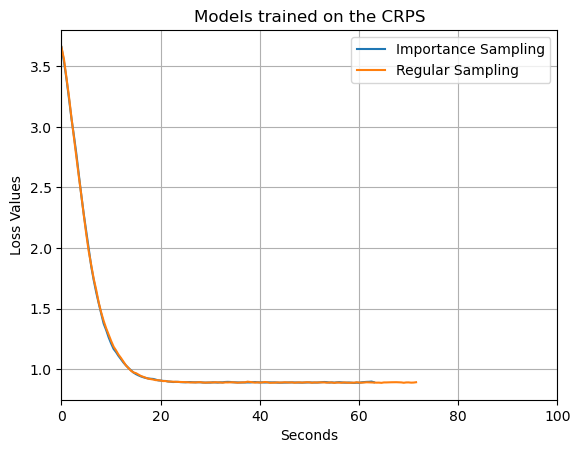

In [59]:
plt.plot(list(losses_is.keys()), list(losses_is.values()), label='Importance Sampling')
plt.plot(list(losses.keys()), list(losses.values()), label='Regular Sampling')
plt.xlabel('Seconds')
plt.ylabel("Loss Values")
plt.xlim(0, 100)
plt.grid()
plt.legend()
plt.title("Models trained on the CRPS")
plt.show()

In [60]:
setup['loss'] = 'loss_twCRPS_sample'

In [61]:
emos_weight_is = EMOS(setup)

emos_weight_base = EMOS(setup)

In [62]:
epochs = 2

losses_is_w = emos_weight_is.fit(train_data_is, epochs, True, test_data)['validation_loss']

Epoch:  0  Loss:  0.111717939
Epoch:  1  Loss:  0.0939979851


In [63]:
epochs = 4

losses_w = emos_weight_base.fit(train_data, epochs, True, test_data)['validation_loss']

Epoch:  0  Loss:  0.240367919
Epoch:  1  Loss:  0.171116933
Epoch:  2  Loss:  0.168058097
Epoch:  3  Loss:  0.167231664


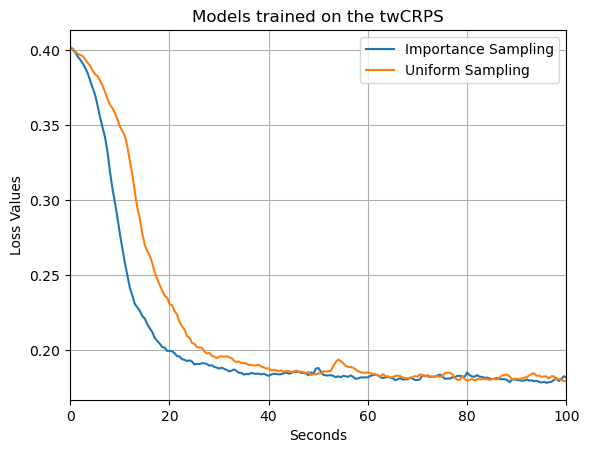

In [64]:
plt.plot(list(losses_is_w.keys()), list(losses_is_w.values()), label='Importance Sampling')
plt.plot(list(losses_w.keys()), list(losses_w.values()), label='Uniform Sampling')
plt.xlabel('Seconds')
plt.ylabel("Loss Values")
plt.grid()
plt.xlim(0, 100)
plt.legend()
plt.title("Models trained on the twCRPS")
plt.show()

In [4]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/base_emos_fold_3'

filepath2 = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/tn_ln_M13_STD2_C07.pkl'

with open(filepath, 'rb') as f:
    emos_base = EMOS(pickle.load(f))

with open(filepath2, 'rb') as f:
    emos_weight = EMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [5]:
print(emos_base.CRPS(test_data, 1000))

print(emos_weight.CRPS(test_data, 1000))

0.8878092
0.8905406


In [6]:
print(emos_base.twCRPS(test_data, [12], 10000))

print(emos_weight.twCRPS(test_data, [12], 10000))

[0.06270537]
[0.0623012]


In [7]:
models = {'emos_weight': emos_weight}

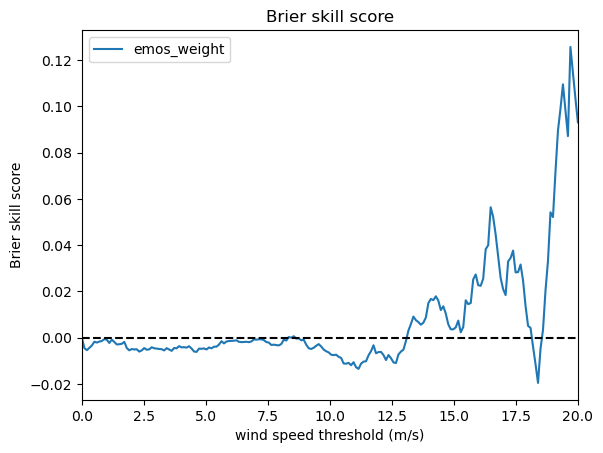

In [11]:
values = np.linspace(0, 20, 200)
ylim = [-0.4, 0.4]
ylim = None
make_brier_skill_plot_tf(emos_base, models, test_data, values, ylim=ylim)

(1000, 40)
(40,)


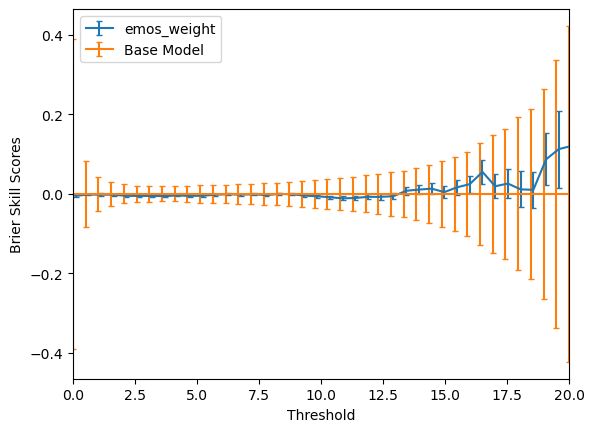

In [9]:
values = np.linspace(0, 20, 40)


make_bootstrap_brier(emos_base, models, test_data, values, bootstrap_size = 1000)

In [25]:
train_data_original, test_data, data_info = load_cv_data(0, features_names_dict)

train_data = train_data_original.batch(len(train_data_original))

X_full, y_full = next(iter(train_data))

## Work of the last 3 weeks

- Implemented constraint for mixture linear model

- Ran MOTPE with smaller search space 

- Worked on importance sampling

- Implemented bootstrapping

- Worked on the GEV distribution for CNNs

#### Constraint for Mixture Linear Model

For the mixture linear I defined the weight by 

$w = \sigma(\alpha + \beta X_w)$

where $\sigma$ is the sigmoid function. I now set the following contraints:

$\alpha \in [4,12] \quad\text{and} \quad\beta \in [-6,-0.6]$

Now all models will use the TN for lower wind speeds and LN/GEV for higher wind speeds


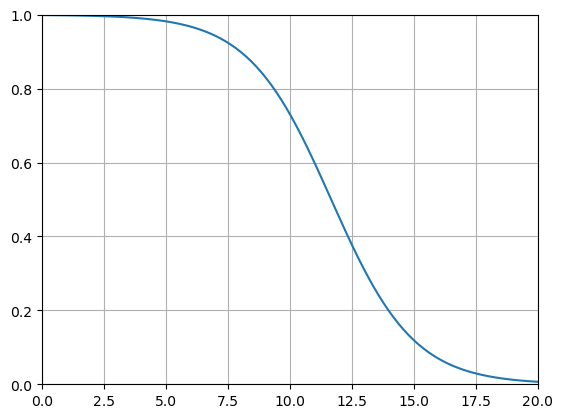

In [30]:
alpha = 7
beta = -0.6
x = np.linspace(0, 20, 200)

y = 1 / (1 + np.exp(-(alpha + beta * x)))
plt.plot(x, y)
plt.xlim(0,20)
plt.ylim(0,1)
plt.grid()
plt.show()

#### Results for Hyperparamter Optimization

#### Implemented Importance Sampling

Made 4 sets, depending on the observation. Then upsampled from these

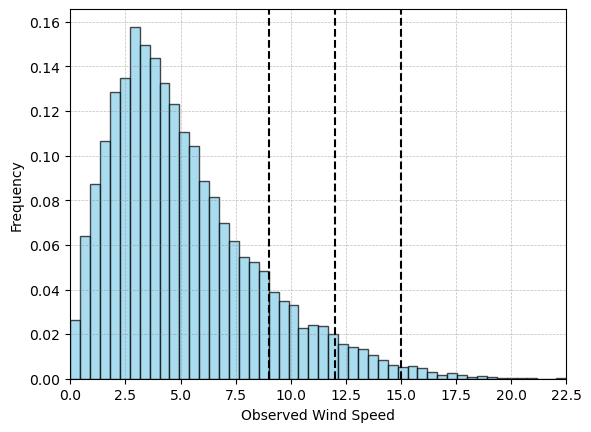

In [28]:
plt.hist(y_full, bins = 50, density=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlim(0, np.max(y_full))
plt.xlabel('Observed Wind Speed')
plt.ylabel('Frequency')

plt.axvline(9, linestyle='--', color='black')
plt.axvline(12, linestyle='--', color='black')
plt.axvline(15, linestyle='--', color='black')

plt.grid(True, color='grey', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

### Questions

- Daniel left out some of the stations in the training and test data because there were missing samples. I also left out these stations, should I keep it that way?

- For the TN and GEV distribution, I do not use the actual mean/variance for the distributions. For the TN is use the mean/std before truncation, for the GEV I use the loc and scale (similar to Lerch)

- For the mixture models: we get two sets of linear equations for the mean and two sets for the variance, that is correct right?